In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
#file_path = '/content/drive/My Drive/Colab Notebooks/yield_df.csv'

# Load the dataset
dataset = pd.read_csv('yield_df.csv')

# Print dataset shape
print("The shape of the dataset is", dataset.shape)

The shape of the dataset is (28242, 8)


In [3]:
# Count missing values in each coluymn
print("Index      Column Name                    Missing Value Count")
print("-------------------------------------------------------------")
for i in dataset:
    count = pd.isnull(dataset[i]).sum()
    print(f"{dataset.columns.get_loc(i):<10} {i:<30} {count}")

Index      Column Name                    Missing Value Count
-------------------------------------------------------------
0          Unnamed: 0                     0
1          Area                           0
2          Item                           0
3          Year                           0
4          hg/ha_yield                    0
5          average_rain_fall_mm_per_year  0
6          pesticides_tonnes              0
7          avg_temp                       0


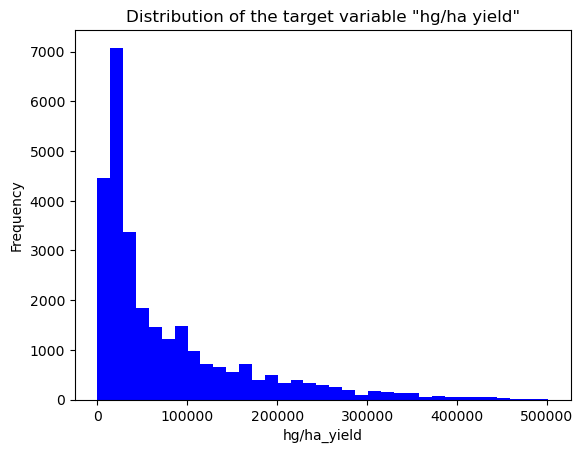

The distribution of hg/ha yield is right-skewed.


In [4]:
#Visual Exploration of the target/dependent variable hg/ha_yield
plt.hist(dataset['hg/ha_yield'],bins=35, color='blue')
plt.title('Distribution of the target variable "hg/ha yield"')
plt.xlabel('hg/ha_yield')
plt.ylabel('Frequency')
plt.show()
print("The distribution of hg/ha yield is right-skewed.")

In [5]:
# Drop the first column (redundent index)
dataset.drop(dataset.columns[0], axis=1, inplace=True)

# Move the target column to the end of the dataframe
column_to_move = dataset.pop('hg/ha_yield')  # Remove the column
dataset['hg/ha_yield'] = column_to_move  # Add it back at the end

# Extract the independent and dependent variables
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

# Extract the column names from X to use again later
X_column_names = X.columns

# Convert to numpy array
X = np.array(X)
y = np.array(y)

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
# Convert X back to a pandas dataframe
X_train = pd.DataFrame(X_train, columns=X_column_names)
X_test = pd.DataFrame(X_test, columns=X_column_names)

# Deal with Categorical columns
# Remove the extra dummy variable
X_train = pd.get_dummies(X_train, columns=['Area', 'Item'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Area', 'Item'], drop_first=True)

# Extract the column names from X to use again later
X_column_names_dummies = X_train.columns

#display(X_train.head(20))
X_train.shape

(22593, 113)

In [7]:
# List of columns to scale (one hot encoded columns are not scaled)
columns_to_scale = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [8]:
#function to print errors
def print_errors(mse,r2):
    print('mean squared error', mse)
    print('root mean squared error', sqrt(mse))
    print('r2_score', r2)

In [9]:
#function for the k-fold cross validation
def k_fold_cross(obj,x,y,model):
    scores = cross_val_score(estimator=obj, X=x, y=y, cv=10, scoring='neg_root_mean_squared_error')
    print("Average RMSE for {0} model after performing k-fold cross validation is {1}".format(model,abs(scores.mean())))

In [10]:
#function to find best n_estimators for RandomForestRegressor
def findBestEstimators(obj,x,y):
    param_grid = {
    'n_estimators': [25,50,100,200]
    }
    grid_search = GridSearchCV(estimator=obj, param_grid=param_grid, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(x, y)
    # Get the best parameters
    best_params = grid_search.best_params_
    print("Best n_estimators for RandomForestRegressor are ",best_params['n_estimators'])
    best_rf = grid_search.best_estimator_
    return best_params,best_rf

In [11]:
#dictionary to store mse,rmse and r2 of original dataset
model_results_before_dim_red = {}

**All features**

**Linear Regression**

In [14]:
# Fit Multiple Linear Regression to Training Set
from sklearn.linear_model import LinearRegression
mlrObj = LinearRegression()
mlrObj.fit(X_train,y_train)

LinearRegression()

In [15]:
#Predicting on the Test Set
y_pred = mlrObj.predict(X_test)

In [16]:
#Calculating MSE and RMSE with all features
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

model_results_before_dim_red = {}

LR_mse_before = mean_squared_error(y_test, y_pred)
LR_rmse_before = sqrt(LR_mse_before)
LR_r2_before = r2_score(y_test, y_pred)

model_results_before_dim_red['Linear Regression'] = {'MSE': LR_mse_before, 'RMSE': LR_rmse_before, 'R2_Score': LR_r2_before}

print_errors(LR_mse_before,LR_r2_before)

mean squared error 1795031951.2726147
root mean squared error 42367.81740038793
r2_score 0.7597313803833203


In [17]:
#K-Fold Cross Validation for Linear Regression model on original data
k_fold_cross(mlrObj,X_train,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 42068.87674618033


**Polynomial Regression w/degree=2**

In [19]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [20]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [21]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_before_dim_red['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 3.232740956011574e+16
root mean squared error 179798246.8215854
r2_score -4327087.476216451


In [22]:
#K-Fold Cross Validation for Polynomial Regression model on original data
k_fold_cross(prObj,X_train,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 42068.87674618033


**Polynomial Regression w/degree=3**

In [24]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [25]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [26]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR3_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_before_dim_red['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 2.9524215471614627e+26
root mean squared error 17182611987592.174
r2_score -3.951875336592782e+16


In [27]:
#K-Fold Cross Validation for Polynomial Regression model on original data
k_fold_cross(prObj,X_train,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 42068.87674618033


**AdaBoost Regression Model**

In [29]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train,y_train)

AdaBoostRegressor()

In [30]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test)

In [31]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_before_dim_red['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 3681715325.892196
root mean squared error 60677.14006025824
r2_score 0.5071950343020128


In [32]:
#K-Fold Cross Validation for AdaBoost model on original data
k_fold_cross(regObj,X_train,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 60902.50750736291


**Gradient Boost Regression Model**

In [34]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train,y_train)

GradientBoostingRegressor()

In [35]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test)

In [36]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_before_dim_red['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 1717591749.0459855
root mean squared error 41443.838493146184
r2_score 0.770096906455788


In [37]:
#K-Fold Cross Validation for GradientBoost model on original data
k_fold_cross(regObj,X_train,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 41166.31004062126


**XGBoost Regression Model**

In [39]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test)

In [41]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_before_dim_red['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 223434742.39969566
root mean squared error 14947.733687743292
r2_score 0.9700928330421448


In [42]:
#K-Fold Cross Validation for XGBoost model on original data
k_fold_cross(regObj,X_train,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 14388.682800357506


**RandomForestRegressor with best estimators**

In [44]:
regObj = RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test)

Best n_estimators for RandomForestRegressor are  200


In [45]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

#model_results_before_dim_red['Random Forest 200'] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}
model_results_before_dim_red['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)


mean squared error 83326839.51553707
root mean squared error 9128.35360377418
r2_score 0.9888465357437094


In [46]:
#K-Fold Cross Validation for RandomForestRegressor model on original data
k_fold_cross(best_rf,X_train,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 9408.048964398069


**Dimensionality reduction - backward elimination**

In [48]:
# Combine rows of one hot encoded and standardized X_train and X_test datasets
X_concat = pd.concat([X_train, X_test], axis=0)
X_concat.head(5)
display(X_concat.shape)

# Convert to numpy array
X_concat = np.array(X_concat)

(28242, 113)

In [49]:
# Backward Elimination prep
import statsmodels.api as sm

# Insert column of ones into index 0 of X_concat
X_concat = np.append(arr=np.ones((len(X_concat),1)), values=X_concat, axis=1)

# Convert to a float64
X_concat = X_concat.astype('float64')  # Without this, OLS function errors out

In [50]:
# Backward elimination loop

def backwardElimination(X, y, SL):
    original_columns = list(range(X.shape[1]))  # Track the original column indices
    while True:
        obj_OLS = sm.OLS(y, X).fit()  # Fit the model
        maxVar = max(obj_OLS.pvalues)  # Get the maximum p-value

        # If the maximum p-value is greater than SL, remove the corresponding feature
        if maxVar > SL:
            maxVarIndex = np.argmax(obj_OLS.pvalues)  # Index of the feature with the max p-value
            X = np.delete(X, maxVarIndex, axis=1)     # Delete the feature column with the highest p-value
            original_columns.pop(maxVarIndex)         # Remove the index from the list of remaining columns
        else:
            break  # Stop if all p-values are below the significance level

    return X, original_columns

In [51]:
display(type(X_concat))
display(X_concat.shape)
display(type(y))
display(y.shape)

numpy.ndarray

(28242, 114)

numpy.ndarray

(28242,)

In [52]:
# Execute backward elimination with 0.05 p-value significance level
SL = 0.05
X_sig, sig_index = backwardElimination(X_concat, y, SL)

In [53]:
# Remove the added ones column from sig_index
sig_index = sig_index[1:]
display(sig_index)

#Retaining only years of experience column
X_train_sig = X_train.iloc[:,sig_index]
X_test_sig = X_test.iloc[:,sig_index]

[22, 38, 60, 67, 106]

In [54]:
#dictionary to add mse,rmse and r2 of all the models after backward elimination
model_results_after_back_elim = {}

**Linear regression**

In [56]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_sig, y_train)

LinearRegression()

In [57]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_sig)

In [58]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_back_elim = {}

model_results_after_back_elim['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 4567815996.751188
root mean squared error 67585.6197482215
r2_score 0.3885886858870091


In [59]:
#K-Fold Cross Validation for Linear Regression model after backward elimination data
k_fold_cross(mlrObj_sig,X_train_sig,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 67022.61939085819


**Polynomial Regression w/degree=2**

In [61]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_sig)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [62]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_sig)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [63]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_back_elim['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 4544960760.529854
root mean squared error 67416.32413985394
r2_score 0.3916479050023123


In [64]:
#K-Fold Cross Validation for Polynomial Regression on  model after backward elimination data
k_fold_cross(prObj,X_train_sig,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 67022.61939085819


**Polynomial Regression w/degree=3**

In [66]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_sig)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [67]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_sig)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [68]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_back_elim['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 4544808448.78285
root mean squared error 67415.19449488261
r2_score 0.39166829223451616


In [69]:
#K-Fold Cross Validation for Polynomial Regression model after backward elimination data
k_fold_cross(prObj,X_train_sig,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 67022.61939085819


**AdaBoost Regression Model**

In [71]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_sig,y_train)

AdaBoostRegressor()

In [72]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_sig)

In [73]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_back_elim['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 4851961400.292441
root mean squared error 69656.02199589381
r2_score 0.3505552548771156


In [74]:
#K-Fold Cross Validation for AdaBoost model after backward elimination data
k_fold_cross(regObj, X_train_sig,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 69218.73784171898


**Gradient Boost Regression Model**

In [76]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_sig,y_train)

GradientBoostingRegressor()

In [77]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_sig)

In [78]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_back_elim['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 4544455277.802209
root mean squared error 67412.57507173427
r2_score 0.3917155648771826


In [79]:
#K-Fold Cross Validation for GradientBoost model after backward elimination data
k_fold_cross(regObj, X_train_sig,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 66885.28195095767


**XGBoost Regression Model**

In [81]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_sig,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [82]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_sig)

In [83]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_back_elim['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 4544458257.5085535
root mean squared error 67412.59717225375
r2_score 0.3917151689529419


In [84]:
#K-Fold Cross Validation for XGBoost model after backward elimination data
k_fold_cross(regObj,X_train_sig,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 66885.29657522209


**RandomForestRegressor with best estimators**

In [86]:
regObj = RandomForestRegressor()

best_model=findBestEstimators(regObj,X_train_sig,y_train)
best_params,best_rf = best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_sig)

Best n_estimators for RandomForestRegressor are  50


In [87]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_back_elim['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 4544874526.255294
root mean squared error 67415.68457158389
r2_score 0.39165944763256877


In [88]:
#K-Fold Cross Validation for RandomForestRegressor model after backward elimination data
k_fold_cross(best_rf,X_train_sig,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 66885.76489935942


**Linear dimensionality reduction - principal component analysis (PCA), n_components = 11**

In [90]:
#Applying PCA
from sklearn.decomposition import PCA
pcaObj = PCA(n_components=11) #Start with n_components=None
X_train_pca = pcaObj.fit_transform(X_train)
X_test_pca = pcaObj.transform(X_test)
components_variance = pcaObj.explained_variance_ratio_
print(components_variance)

[0.24680375 0.19215969 0.15605659 0.11666065 0.02572885 0.02443538
 0.0218341  0.02049129 0.01956284 0.01857763 0.01785378]


**Linear regression**

In [92]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_pca, y_train)

LinearRegression()

In [93]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_pca)

In [94]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_pca_11 = {}

model_results_after_pca_11['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 3217522566.593472
root mean squared error 56723.21012243112
r2_score 0.5693281642631205


In [95]:
#K-Fold Cross Validation for Linear Regression model for pca n_components = 11
k_fold_cross(mlrObj_sig,X_train_pca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 56150.26566411939


**Polynomial Regression w/degree=2**

In [97]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_pca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [98]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_pca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [99]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_pca_11['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 2072061077.577601
root mean squared error 45519.89760069327
r2_score 0.7226504773254533


In [100]:
#K-Fold Cross Validation for Polynomial Regression model for pca n_components = 11
k_fold_cross(prObj,X_train_pca,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 56150.26566411939


**Polynomial Regression w/degree=3**

In [102]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_pca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [103]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_pca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [104]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_pca_11['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 892376734.6626586
root mean squared error 29872.67538508492
r2_score 0.880553587882696


In [105]:
#K-Fold Cross Validation for Polynomial Regression model for pca n_components = 11
k_fold_cross(prObj,X_train_pca,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 56150.26566411939


**AdaBoost Regression Model**

In [107]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_pca,y_train)

AdaBoostRegressor()

In [108]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_pca)

In [109]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_pca_11['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2895516931.460454
root mean squared error 53810.007725891046
r2_score 0.6124292630526721


In [110]:
#K-Fold Cross Validation for AdaBoost model after pca n_components = 11
k_fold_cross(regObj,X_train_pca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 51119.896389526824


**Gradient Boost Regression Model**

In [112]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_pca,y_train)

GradientBoostingRegressor()

In [113]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_pca)

In [114]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_pca_11['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 1364912723.3072407
root mean squared error 36944.72524335836
r2_score 0.817303699973824


In [115]:
#K-Fold Cross Validation for GradientBoost model after pca n_components = 11
k_fold_cross(regObj,X_train_pca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 34996.374551728426


**XGBoost Regression Model**

In [117]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_pca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [118]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_pca)

In [119]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_pca_11['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 402622803.5522976
root mean squared error 20065.462953849274
r2_score 0.9461081027984619


In [120]:
#K-Fold Cross Validation for XGBoost model after pca n_components = 11
k_fold_cross(regObj,X_train_pca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 19116.275376781163


**RandomForestRegressor with best estimators**

In [122]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_pca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_pca)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best n_estimators for RandomForestRegressor are  200


In [123]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_pca_11['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 301591971.5655954
root mean squared error 17366.40352996542
r2_score 0.9596313109389698


In [124]:
#K-Fold Cross Validation for RandomForestRegressor model after pca n_components = 11
k_fold_cross(best_rf,X_train_pca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 16889.62362814258


**Linear dimensionality reduction - principal component analysis (PCA), n_components = 0.95 (%)**

In [126]:
#Applying PCA
from sklearn.decomposition import PCA
pcaObj = PCA(n_components=0.95) #Start with n_components=None
X_train_pca = pcaObj.fit_transform(X_train)
X_test_pca = pcaObj.transform(X_test)
components_variance = pcaObj.explained_variance_ratio_
print(components_variance)

[0.24680375 0.19215969 0.15605659 0.11666065 0.02572885 0.02443538
 0.0218341  0.02049129 0.01956284 0.01857763 0.01785378 0.00897626
 0.00733669 0.00644145 0.00587337 0.00518885 0.00460725 0.00411484
 0.00391085 0.00364478 0.00339451 0.00334607 0.00305996 0.00269267
 0.00222557 0.00218068 0.00204467 0.00198479 0.00183729 0.00172785
 0.00163368 0.00157033 0.00154236 0.00147121 0.00144341 0.00139423
 0.0013668  0.0012963  0.00126862 0.00126025 0.00125186]


**Linear regression**

In [128]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_pca, y_train)

LinearRegression()

In [129]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_pca)

In [130]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_pca_95 = {}

model_results_after_pca_95['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 2527178812.5955505
root mean squared error 50271.05342635611
r2_score 0.6617320575289104


In [131]:
#K-Fold Cross Validation for Linear Regression model after pca n_components = 0.95
k_fold_cross(mlrObj_sig,X_train_pca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 49822.686762884136


**Polynomial Regression w/degree=2**

In [133]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_pca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [134]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_pca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [135]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_pca_95['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 518325861.19294155
root mean squared error 22766.7709874049
r2_score 0.9306210459974475


In [136]:
#K-Fold Cross Validation for Polynomial Regression model after pca n_components = 0.95
k_fold_cross(prObj,X_train_pca,y_train,'Polynomial Regression')

Average RMSE for Polynomial Regression model after performing k-fold cross validation is 49822.686762884136


**Polynomial Regression w/degree=3**

In [138]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_pca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [139]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_pca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [140]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_pca_95['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 168686992.92753568
root mean squared error 12987.955687002312
r2_score 0.9774209083524931


In [141]:
#K-Fold Cross Validation for Polynomial Regression model after pca n_components = 0.95
k_fold_cross(prObj,X_train_pca,y_train,'Polynomial Regression')

Average RMSE for Polynomial Regression model after performing k-fold cross validation is 49822.686762884136


**AdaBoost Regression Model**

In [143]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_pca,y_train)

AdaBoostRegressor()

In [144]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_pca)

In [145]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_pca_95['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2609689946.545101
root mean squared error 51085.124513356146
r2_score 0.6506877770953448


In [146]:
#K-Fold Cross Validation for AdaBoost model after pca n_components = 0.95
k_fold_cross(regObj,X_train_pca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 50580.31353943829


**Gradient Boost Regression Model**

In [148]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_pca,y_train)

GradientBoostingRegressor()

In [149]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_pca)

In [150]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_pca_95['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 896466538.1952057
root mean squared error 29941.05105361543
r2_score 0.8800061594937073


In [151]:
#K-Fold Cross Validation for GradientBoost model after pca n_components = 0.95
k_fold_cross(regObj,X_train_pca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 28268.99309428306


**XGBoost Regression Model**

In [153]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_pca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [154]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_pca)

In [155]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_pca_95['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 171471111.99272522
root mean squared error 13094.697858015863
r2_score 0.9770482778549194


In [156]:
#K-Fold Cross Validation for XGBoost model after pca n_components = 0.95
k_fold_cross(regObj,X_train_pca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 12889.276880288435


**RandomForestRegressor with best estimators**

In [158]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_pca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_pca)


Best n_estimators for RandomForestRegressor are  200


In [159]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_pca_95['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 120490349.35700239
root mean squared error 10976.809616505261
r2_score 0.9838721255648882


In [160]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_pca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 11676.126953703457


**Polynomial dimensionality reduction - RBF kernel principal component analysis (kernel PCA), n_components=11**

In [162]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=11, kernel='rbf')
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [164]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [165]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [166]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_rbf = {}

model_results_after_rbf['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 3191320212.0863385
root mean squared error 56491.771189141684
r2_score 0.5728354018605752


In [167]:
#K-Fold Cross Validation for Linear model after pca kernel = rbf
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 55866.282288573544


**Polynomial Regression w/degree=2**

In [169]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [170]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [171]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_rbf['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 2049100111.6445203
root mean squared error 45266.98699543101
r2_score 0.7257238485743025


In [172]:
#K-Fold Cross Validation for Polynomial Regression model after pca kernel = rbf
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree 2')

Average RMSE for Polynomial Regression w/degree 2 model after performing k-fold cross validation is 55866.282288573544


**Polynomial Regression w/degree=3**

In [174]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [175]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [176]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_rbf['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 1006288319.2092962
root mean squared error 31722.047840725798
r2_score 0.8653062942855179


In [177]:
#K-Fold Cross Validation for Polynomial Regression model after pca kernel = rbf
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree 3')

Average RMSE for Polynomial Regression w/degree 3 model after performing k-fold cross validation is 55866.282288573544


**AdaBoost Regression Model**

In [179]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [180]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [181]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_rbf['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2312237418.0774727
root mean squared error 48085.72987984557
r2_score 0.6905023934121961


In [182]:
#K-Fold Cross Validation for AdaBoost model after pca kernel = rbf
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 49877.222891389974


**Gradient Boost Regression Model**

In [184]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [185]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [186]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_rbf['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 1307631360.0089617
root mean squared error 36161.18582138813
r2_score 0.8249709251057675


In [187]:
#K-Fold Cross Validation for GradientBoost model after pca kernel = rbf
k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 34089.36716089597


**XGBoost Regression Model**

In [189]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [190]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [191]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_rbf['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 506437280.54857713
root mean squared error 22504.161405139654
r2_score 0.9322123527526855


In [192]:
#K-Fold Cross Validation for XGBoost model after pca kernel = rbf
k_fold_cross(regObj,X_train_pca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 12889.276880288435


**RandomForestRegressor with best estimators**

In [194]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)



Best n_estimators for RandomForestRegressor are  200


In [195]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_rbf['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 399089714.12915874
root mean squared error 19977.229891282692
r2_score 0.9465810429451985


In [196]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 18174.084242626835


**Polynomial dimensionality reduction - RBF kernel principal component analysis (kernel PCA), n_components=41 (~95%)**

In [198]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=41, kernel='rbf')
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [200]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [201]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [202]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_rbf_95 = {}

model_results_after_rbf_95['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 2504817592.471389
root mean squared error 50048.15273785226
r2_score 0.6647251516007837


In [203]:
#K-Fold Cross Validation for Linear Regression model after pca kernel = rbf
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 49592.885835835


**Polynomial Regression w/degree=2**

In [205]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [206]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [207]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_rbf_95['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 479270520.85880435
root mean squared error 21892.247962664875
r2_score 0.9358486814744038


In [208]:
#K-Fold Cross Validation for Polynomial Regression model after pca kernel = rbf
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree 2')

Average RMSE for Polynomial Regression w/degree 2 model after performing k-fold cross validation is 49592.885835835


**Polynomial Regression w/degree=3**

In [210]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [211]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [212]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_rbf_95['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 710859416214266.8
root mean squared error 26661946.969684467
r2_score -95148.9557176302


In [213]:
#K-Fold Cross Validation for Polynomal Regression model after pca kernel = rbf
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree 3')

Average RMSE for Polynomial Regression w/degree 3 model after performing k-fold cross validation is 49592.885835835


**AdaBoost Regression Model**

In [215]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [216]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [217]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_rbf_95['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 3027579499.6255145
root mean squared error 55023.444999613705
r2_score 0.59475242396713


In [218]:
#K-Fold Cross Validation for AdaBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 53394.19891890518


**Gradient Boost Regression Model**

In [220]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [221]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [222]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_rbf_95['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 975988391.2614073
root mean squared error 31240.812909740478
r2_score 0.8693620002897273


In [223]:
#K-Fold Cross Validation for GradientBoost model

k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 29331.592522747647


**XGBoost Regression Model**

In [225]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [226]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [227]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_rbf_95['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 242903836.42832103
root mean squared error 15585.372514903871
r2_score 0.9674868583679199


In [228]:
#K-Fold Cross Validation for XGBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 15139.623923922132


**Random Forest Regression with best estimators**

In [230]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)


Best n_estimators for RandomForestRegressor are  200


In [231]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_rbf_95['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)


mean squared error 180292874.18969706
root mean squared error 13427.31820542349
r2_score 0.9758674379152021


In [232]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 13257.972095562902


**Polynomial dimensionality reduction - linear kernel principal component analysis (kernel PCA), n_components=11**

In [234]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=11, kernel='linear')
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [236]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [237]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [238]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_kernal_11 = {}

model_results_after_kernal_11['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 3217522566.593469
root mean squared error 56723.21012243109
r2_score 0.5693281642631209


In [239]:
#K-Fold Cross Validation for Linear Regression model
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 56150.265664119375


**Polynomial Regression w/degree=2**

In [241]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [242]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [243]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_kernal_11['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 2072061077.5776072
root mean squared error 45519.89760069334
r2_score 0.7226504773254525


In [244]:
#K-Fold Cross Validation for Polynomial Regression model

k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 56150.265664119375


**Polynomial Regression w/degree=3**

In [246]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [247]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [248]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_kernal_11['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 892376734.6625817
root mean squared error 29872.675385083636
r2_score 0.8805535878827063


In [249]:
#K-Fold Cross Validation for Polynomial Regression model

k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 56150.265664119375


**AdaBoost Regression Model**

In [251]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [252]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [253]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_kernal_11['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2463949182.013103
root mean squared error 49638.18270256379
r2_score 0.6701954701429014


In [254]:
#K-Fold Cross Validation for AdaBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 50180.730798720746


**Gradient Boost Regression Model**

In [256]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [257]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [258]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_kernal_11['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 1364842371.8663433
root mean squared error 36943.773113561954
r2_score 0.8173131166550037


In [259]:
#K-Fold Cross Validation for GradientBoost model

k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 34997.05373002369


**XGBoost Regression Model**

In [261]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [262]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [263]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_kernal_11['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 387873196.5314797
root mean squared error 19694.49660518084
r2_score 0.9480823874473572


In [264]:
#K-Fold Cross Validation for XGBoost model

k_fold_cross(regObj,X_train_kpca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 19195.76425433606


**Random Forest Regression with best estimators**

In [266]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)


Best n_estimators for RandomForestRegressor are  200


In [268]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_kernal_11['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 309704019.24853694
root mean squared error 17598.40956588228
r2_score 0.9585454971195204


In [270]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 16799.922241169268


**Polynomial dimensionality reduction - linear kernel principal component analysis (kernel PCA), n_components=41 (~95%)**

In [272]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=41, kernel='linear')
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [274]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [275]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [276]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_kernal_95 = {}

model_results_after_kernal_95['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 2527178812.5955453
root mean squared error 50271.05342635606
r2_score 0.6617320575289112


In [277]:
#K-Fold Cross Validation for Linear Regression model
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 49822.6867628841


**Polynomial Regression w/degree=2**

In [279]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [280]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [281]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_kernal_95['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 518289322.6617764
root mean squared error 22765.968520178896
r2_score 0.9306259367529796


In [282]:
#K-Fold Cross Validation for Polynomial Regression model

k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 49822.6867628841


**Polynomial Regression w/degree=3**

In [284]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [285]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [286]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_kernal_95['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 1515374708.6273189
root mean squared error 38927.814074608905
r2_score 0.7971640620737798


In [287]:
#K-Fold Cross Validation for Polynomial Regression model

k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 49822.6867628841


**AdaBoost Regression Model**

In [289]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [290]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [291]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_kernal_95['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2608029828.8678446
root mean squared error 51068.873385535386
r2_score 0.6509099871693398


In [292]:
#K-Fold Cross Validation for AdaBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 49319.80722725335


**Gradient Boost Regression Model**

In [294]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [295]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [296]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_kernal_95['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 896370676.8944958
root mean squared error 29939.45017689029
r2_score 0.8800189907206835


In [297]:
#K-Fold Cross Validation for GradientBoost model

k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 28263.84218674266


**XGBoost Regression Model**

In [299]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [300]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [301]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_kernal_95['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 159710880.0486579
root mean squared error 12637.677003652921
r2_score 0.9786223769187927


In [302]:
#K-Fold Cross Validation for XGBoost model

k_fold_cross(regObj,X_train_kpca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 12906.647985257247


**Random Forest Regression with best estimators**

In [304]:
#Create and Fit a Regressor Object
from sklearn.ensemble import RandomForestRegressor
regObj = RandomForestRegressor(n_estimators=25)
regObj.fit(X_train_kpca,y_train)

RandomForestRegressor(n_estimators=25)

In [305]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)


Best n_estimators for RandomForestRegressor are  200


In [306]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_kernal_95['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 120147360.61009628
root mean squared error 10961.1751473141
r2_score 0.9839180352951884


In [307]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 11640.052646499866


**Polynomial dimensionality reduction - sigmoid kernel principal component analysis (kernel PCA), n_components=11**

In [309]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=11, kernel='sigmoid')
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [311]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [312]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [313]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_sigmoid_11 = {}

model_results_after_sigmoid_11['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 3221633540.535975
root mean squared error 56759.43569606709
r2_score 0.5687779021723844


In [314]:
#K-Fold Cross Validation for Linear Regression model
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 56192.315222881734


**Polynomial Regression w/degree=2**

In [316]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [317]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [318]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_sigmoid_11['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)


mean squared error 2074048345.9260714
root mean squared error 45541.720937246886
r2_score 0.7223844774792909


In [319]:
#K-Fold Cross Validation for Polynomial Regression model

k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 56192.315222881734


**Polynomial Regression w/degree=3**

In [321]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [322]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [323]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_sigmoid_11['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 937952751.0854858
root mean squared error 30626.014286640137
r2_score 0.8744531468594728


In [324]:
#K-Fold Cross Validation for Polynomial Regression model

k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 56192.315222881734


**AdaBoost Regression Model**

In [326]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [327]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [328]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_sigmoid_11['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2167929635.857033
root mean squared error 46561.031301476054
r2_score 0.7098182789090909


In [329]:
#K-Fold Cross Validation for AdaBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 48565.0503419413


**Gradient Boost Regression Model**

In [331]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [332]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [333]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_sigmoid_11['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 1325587485.5720592
root mean squared error 36408.61828704928
r2_score 0.8225674617581371


In [334]:
#K-Fold Cross Validation for GradientBoost model

k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 34508.370031269485


**XGBoost Regression Model**

In [336]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [337]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [338]:

#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_sigmoid_11['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 419392541.0026365
root mean squared error 20479.075687213925
r2_score 0.9438634514808655


In [339]:
#K-Fold Cross Validation for XGBoost model

k_fold_cross(regObj,X_train_kpca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 19329.77913948364


**Random Forest Regression with best estimators**

In [341]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)

Best n_estimators for RandomForestRegressor are  200


In [342]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_sigmoid_11['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 294009871.35820013
root mean squared error 17146.71605171673
r2_score 0.9606461902280736


In [343]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 16602.022942257056


**Polynomial dimensionality reduction - sigmoid kernel principal component analysis (kernel PCA), n_components=41 (~95%)**

In [345]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=41, kernel='sigmoid')
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [347]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [348]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [349]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_sigmoid_95 = {}

model_results_after_sigmoid_95['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 2482613703.38719
root mean squared error 49825.83369485341
r2_score 0.6676971865980437


In [350]:
#K-Fold Cross Validation for Linear Regression model
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 49501.86761338836


**Polynomial Regression w/degree=2**

In [352]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [353]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [354]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_sigmoid_95['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)


mean squared error 461458891.92200345
root mean squared error 21481.594259318917
r2_score 0.9382328036593797


In [355]:
#K-Fold Cross Validation for Polynomial Regression model
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 49501.86761338836


**Polynomial Regression w/degree=3**

In [357]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [358]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [359]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_sigmoid_95['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 2531695554730016.5
root mean squared error 50315957.257415034
r2_score -338871.5174465061


In [360]:
#K-Fold Cross Validation for Polynomial Regression model
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 49501.86761338836


**AdaBoost Regression Model**

In [362]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [363]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [364]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_sigmoid_95['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2505649230.9591346
root mean squared error 50056.46043178777
r2_score 0.6646138351245899


In [365]:
#K-Fold Cross Validation for AdaBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 50968.38052482527


**Gradient Boost Regression Model**

In [367]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [368]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [369]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_sigmoid_95['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 877027926.1504921
root mean squared error 29614.657285717356
r2_score 0.8826080566242493


In [370]:
#K-Fold Cross Validation for GradientBoost model

k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 27534.536185367022


**XGBoost Regression Model**

In [372]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [373]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [374]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_sigmoid_95['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 162058065.58209583
root mean squared error 12730.202888489084
r2_score 0.9783082008361816


In [375]:
#K-Fold Cross Validation for XGBoost model

k_fold_cross(regObj,X_train_kpca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 12745.835780762714


**Random Forest Regression with best estimators**

In [377]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)


Best n_estimators for RandomForestRegressor are  200


In [378]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_sigmoid_95['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 137061530.85519972
root mean squared error 11707.32808352101
r2_score 0.9816540397524509


In [379]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 11657.280490981384


**Polynomial dimensionality reduction - polynomial kernel principal component analysis (kernel PCA) w/degree=2, n_components=11**

In [381]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=11, kernel='poly', degree=2)
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [383]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [384]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [385]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_poly_11 = {}

model_results_after_poly_11['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 3212809062.196405
root mean squared error 56681.646608019466
r2_score 0.5699590762612259


In [386]:
#K-Fold Cross Validation for Linear Regression model
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 56103.04237363445


**Polynomial Regression w/degree=2**

In [388]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [389]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [390]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_poly_11['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 2066736605.9294615
root mean squared error 45461.37487944531
r2_score 0.7233631685130277


In [391]:
#K-Fold Cross Validation for Polynomial Regression model
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 56103.04237363445


**Polynomial Regression w/degree=3**

In [393]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [394]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [395]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_poly_11['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 902970761.7570748
root mean squared error 30049.47190479518
r2_score 0.8791355561510867


In [396]:
#K-Fold Cross Validation for Polynomial Regression model
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 56103.04237363445


**AdaBoost Regression Model**

In [427]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [428]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [429]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_11['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)


mean squared error 2708961883.4646044
root mean squared error 52047.68855064175
r2_score 0.6374000296358007


In [430]:
#K-Fold Cross Validation for AdaBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 51839.22641259189


**Gradient Boost Regression Model**

In [432]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [433]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [434]:
# Gradient Boost

GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_11['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 1336061123.2548957
root mean squared error 36552.16988435701
r2_score 0.8211655443902395


In [435]:
#K-Fold Cross Validation for GradientBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 34274.110150647495


**XGBoost Regression Model**

In [437]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [438]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [439]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_11['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 407603937.4878521
root mean squared error 20189.203488197647
r2_score 0.9454414248466492


In [440]:
#K-Fold Cross Validation for XGBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 19961.535942412345


**Random Forest Regression with best estimators**

In [442]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)

Best n_estimators for RandomForestRegressor are  200


In [443]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_poly_11['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 263913478.261223
root mean squared error 16245.414068629429
r2_score 0.9646746526850928


In [444]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 16913.938275968827


**Polynomial dimensionality reduction - polynomial kernel principal component analysis (kernel PCA) w/degree=2, n_components=41 (~95%)**

In [446]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=41, kernel='poly', degree=2)
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [448]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [449]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [450]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_poly_95 = {}

model_results_after_poly_95['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 2489250466.6024337
root mean squared error 49892.38886445941
r2_score 0.6668088425575274


In [451]:
#K-Fold Cross Validation for Linear Regression model
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 49529.145963387375


**Polynomial Regression w/degree=2**

In [453]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [454]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [455]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_poly_95['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 460000533.89803106
root mean squared error 21447.62303608563
r2_score 0.9384280077999402


In [456]:
#K-Fold Cross Validation for Polynomial Regression model
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 49529.145963387375


**Polynomial Regression w/degree=3**

In [458]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [459]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [460]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_poly_95['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 4.522683889247901e+16
root mean squared error 212666026.6532457
r2_score -6053701.911871769


In [461]:
#K-Fold Cross Validation for Polynomial Regression model
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 49529.145963387375


**AdaBoost Regression Model**

In [463]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [464]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [465]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_95['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2345145163.458863
root mean squared error 48426.69887013632
r2_score 0.6860976258247009


In [466]:
#K-Fold Cross Validation for AdaBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 51973.35271831796


**Gradient Boost Regression Model**

In [468]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [469]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [470]:
#Gradient Boost

GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_95['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 884428309.4594241
root mean squared error 29739.339425404596
r2_score 0.8816175005057296


In [471]:
#K-Fold Cross Validation for GradientBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 27935.067392393707


**XGBoost Regression Model**

In [473]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [474]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [475]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_95['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 179791140.78480995
root mean squared error 13408.621882386346
r2_score 0.975934624671936


In [476]:
#K-Fold Cross Validation for XGBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 13239.258769733893


**Random Forest Regression with best estimators**

In [478]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)


Best n_estimators for RandomForestRegressor are  200


In [479]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_poly_95['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 127158998.11653696
root mean squared error 11276.479863704673
r2_score 0.9829795135804464


In [480]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 11819.269251616466


**Polynomial dimensionality reduction - polynomial kernel principal component analysis (kernel PCA) w/degree=3, n_components=11**

In [482]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=11, kernel='poly', degree=3)
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [484]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [485]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [486]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_poly_11_3 = {}

model_results_after_poly_11_3['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 3205325841.455418
root mean squared error 56615.59715710343
r2_score 0.5709607203358338


In [487]:
#K-Fold Cross Validation for Linear Regression model
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 56030.0463243058


**Polynomial Regression w/degree=2**

In [489]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [490]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [491]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_poly_11_3['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 2062243449.553422
root mean squared error 45411.93069616642
r2_score 0.7239645864874696


In [492]:
#K-Fold Cross Validation for Polynomial Regression model

k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 56030.0463243058


**Polynomial Regression w/degree=3**

In [494]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [495]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [496]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_poly_11_3['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 943525567.733405
root mean squared error 30716.861293651164
r2_score 0.8737072141965901


In [497]:
#K-Fold Cross Validation for Polynomial Regression model
k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 56030.0463243058


**AdaBoost Regression Model**

In [499]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [500]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [501]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_11_3['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2098315990.3188798
root mean squared error 45807.37921251204
r2_score 0.7191362047031575


In [502]:
#K-Fold Cross Validation for AdaBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 50136.2493476415


**Gradient Boost Regression Model**

In [504]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [505]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [506]:
GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_11_3['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 1354336387.8976655
root mean squared error 36801.30959487265
r2_score 0.8187193636380056


In [507]:
#K-Fold Cross Validation for GradientBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 34538.13753138047


**XGBoost Regression Model**

In [509]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [510]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [511]:
XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_11_3['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 427865570.5817858
root mean squared error 20684.911664829167
r2_score 0.9427293539047241


In [512]:
#K-Fold Cross Validation for XGBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 20906.205696230263


**Random Forest Regression with best estimators**

In [514]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)


Best n_estimators for RandomForestRegressor are  100


In [515]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_poly_11_3['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 308373781.52836
root mean squared error 17560.574635482746
r2_score 0.958723552100972


In [516]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 17515.265688073072


**Polynomial dimensionality reduction - polynomial kernel principal component analysis (kernel PCA) w/degree=3, n_components=41**

In [518]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=41, kernel='poly', degree=3)
X_train_kpca = kernelPCAObj.fit_transform(X_train)
X_test_kpca = kernelPCAObj.transform(X_test)

**Linear regression**

In [520]:
#Building a model with significant predictor
mlrObj_sig = LinearRegression()
mlrObj_sig.fit(X_train_kpca, y_train)

LinearRegression()

In [521]:
#Predicting on the Test Set with only sig features
y_sig_pred = mlrObj_sig.predict(X_test_kpca)

In [522]:
#Calculating MSE and RMSE
lr_mse = mean_squared_error(y_test, y_sig_pred)
lr_rmse = sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_sig_pred)

model_results_after_poly_95_3 = {}

model_results_after_poly_95_3['Linear Regression'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'R2_Score': lr_r2}

print_errors(lr_mse,lr_r2)

mean squared error 2497974304.3250546
root mean squared error 49979.73893814427
r2_score 0.665641139416707


In [523]:
#K-Fold Cross Validation for Linear Regression model
k_fold_cross(mlrObj_sig,X_train_kpca,y_train,'Linear Regression')

Average RMSE for Linear Regression model after performing k-fold cross validation is 49604.85744033718


**Polynomial Regression w/degree=2**

In [525]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=2)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [526]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [527]:
#Calculating MSE and RMSE

PR2_mse_before = mean_squared_error(y_test, y_pred)
PR2_rmse_before = sqrt(PR2_mse_before)
PR2_r2_before = r2_score(y_test, y_pred)

model_results_after_poly_95_3['Polynomial Regrssion degree 2'] = {'MSE': PR2_mse_before, 'RMSE': PR2_rmse_before, 'R2_Score': PR2_r2_before}

print_errors(PR2_mse_before, PR2_r2_before)

mean squared error 487112730.9020967
root mean squared error 22070.630505313995
r2_score 0.9347989859631289


In [528]:
#K-Fold Cross Validation for Polynomial Regression model

k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=2')

Average RMSE for Polynomial Regression w/degree=2 model after performing k-fold cross validation is 49604.85744033718


**Polynomial Regression w/degree=3**

In [530]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

polyFeatureObj = PolynomialFeatures(degree=3)
X_poly = polyFeatureObj.fit_transform(X_train_kpca)
X_poly = X_poly[:,1:] #dropping the intercept column as that will be added by sklearn
prObj = LinearRegression()
prObj.fit(X_poly, y_train)

LinearRegression()

In [531]:
#Predicting on the Test Set
X_test_poly = polyFeatureObj.transform(X_test_kpca)
X_test_poly = X_test_poly[:,1:] #dropping the intercept column as that will be added by sklearn
y_pred = prObj.predict(X_test_poly)

In [532]:
#Calculating MSE and RMSE

PR3_mse_before = mean_squared_error(y_test, y_pred)
PR3_rmse_before = sqrt(PR2_mse_before)
PR3_r2_before = r2_score(y_test, y_pred)

model_results_after_poly_95_3['Polynomial Regrssion degree 3'] = {'MSE': PR3_mse_before, 'RMSE': PR3_rmse_before, 'R2_Score': PR3_r2_before}

print_errors(PR3_mse_before, PR3_r2_before)

mean squared error 365159197971280.2
root mean squared error 19109139.121668465
r2_score -48876.289551693706


In [533]:
#K-Fold Cross Validation for Polynomial Regression model

k_fold_cross(prObj,X_train_kpca,y_train,'Polynomial Regression w/degree=3')

Average RMSE for Polynomial Regression w/degree=3 model after performing k-fold cross validation is 49604.85744033718


**AdaBoost Regression Model**

In [535]:
#Create and Fit a Regressor Object
from sklearn.ensemble import AdaBoostRegressor
regObj = AdaBoostRegressor()
regObj.fit(X_train_kpca,y_train)

AdaBoostRegressor()

In [536]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [537]:
#Calculating MSE and RMSE

AdaBoost_mse = mean_squared_error(y_test, y_pred)
AdaBoost_rmse = sqrt(AdaBoost_mse)
AdaBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_95_3['AdaBoost'] = {'MSE': AdaBoost_mse, 'RMSE': AdaBoost_rmse, 'R2_Score': AdaBoost_r2}

print_errors(AdaBoost_mse,AdaBoost_r2)

mean squared error 2629562021.8998027
root mean squared error 51279.25527832676
r2_score 0.64802786003314


In [538]:
#K-Fold Cross Validation for AdaBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'AdaBoost')

Average RMSE for AdaBoost model after performing k-fold cross validation is 49725.6710555953


**Gradient Boost Regression Model**

In [540]:
#Create and Fit a Regressor Object
from sklearn.ensemble import GradientBoostingRegressor
regObj = GradientBoostingRegressor()
regObj.fit(X_train_kpca,y_train)

GradientBoostingRegressor()

In [541]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [542]:
#Calculating MSE and RMSE

GradientBoost_mse = mean_squared_error(y_test, y_pred)
GradientBoost_rmse = sqrt(GradientBoost_mse)
GradientBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_95_3['Gradient Boost'] = {'MSE': GradientBoost_mse, 'RMSE': GradientBoost_rmse, 'R2_Score': GradientBoost_r2}

print_errors(GradientBoost_mse,GradientBoost_r2)

mean squared error 871205102.8024955
root mean squared error 29516.18374388016
r2_score 0.8833874531843513


In [543]:
#K-Fold Cross Validation for GradientBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'GradientBoost')

Average RMSE for GradientBoost model after performing k-fold cross validation is 28023.901248438953


**XGBoost Regression Model**

In [545]:
#Create and Fit a Regressor Object
from xgboost import XGBRegressor
regObj = XGBRegressor()
regObj.fit(X_train_kpca,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [546]:
#Predicting on the Test Set
y_pred = regObj.predict(X_test_kpca)

In [547]:
#Calculating MSE and RMSE

XGBoost_mse = mean_squared_error(y_test, y_pred)
XGBoost_rmse = sqrt(XGBoost_mse)
XGBoost_r2 = r2_score(y_test, y_pred)

model_results_after_poly_95_3['XG Boost'] = {'MSE': XGBoost_mse, 'RMSE': XGBoost_rmse, 'R2_Score': XGBoost_r2}

print_errors(XGBoost_mse,XGBoost_r2)

mean squared error 165086150.82729283
root mean squared error 12848.585557457009
r2_score 0.977902889251709


In [548]:
#K-Fold Cross Validation for XGBoost model
k_fold_cross(regObj,X_train_kpca,y_train,'XGBoost')

Average RMSE for XGBoost model after performing k-fold cross validation is 13549.82292414871


**Random Forest Regression with best estimators**

In [550]:
regObj=RandomForestRegressor()
best_model=findBestEstimators(regObj,X_train_kpca,y_train)
best_params,best_rf=best_model

#Predicting on the Test Set
y_pred = best_rf.predict(X_test_kpca)


Best n_estimators for RandomForestRegressor are  100


In [551]:
#Calculating MSE and RMSE
RFR_mse = mean_squared_error(y_test, y_pred)
RFR_rmse = sqrt(RFR_mse)
RFR_r2 = r2_score(y_test, y_pred)

model_results_after_poly_95_3['Random Forest '+str(best_params['n_estimators'])] = {'MSE': RFR_mse, 'RMSE': RFR_rmse, 'R2_Score': RFR_r2}

print_errors(RFR_mse,RFR_r2)

mean squared error 143090383.08431724
root mean squared error 11962.039252749391
r2_score 0.9808470658142232


In [552]:
#K-Fold Cross Validation for RandomForestRegressor model
k_fold_cross(best_rf,X_train_kpca,y_train,'RandomForestRegressor')

Average RMSE for RandomForestRegressor model after performing k-fold cross validation is 12241.427262645633


**Results Bar Charts**

In [768]:
# All Dictionary Names
#model_results_before_dim_red
#model_results_after_back_elim
#model_results_after_pca_11
#model_results_after_pca_95
#model_results_after_rbf
#model_results_after_rbf_95
#model_results_after_kernal_11
#model_results_after_kernal_95
#model_results_after_sigmoid_11
#model_results_after_sigmoid_95
#model_results_after_poly_11
#model_results_after_poly_95
#model_results_after_poly_11_3
#model_results_after_poly_95_3

{'Linear Regression': {'MSE': 2497974304.3250546,
  'RMSE': 49979.73893814427,
  'R2_Score': 0.665641139416707},
 'Polynomial Regrssion degree 2': {'MSE': 487112730.9020967,
  'RMSE': 22070.630505313995,
  'R2_Score': 0.9347989859631289},
 'Polynomial Regrssion degree 3': {'MSE': 365159197971280.2,
  'RMSE': 22070.630505313995,
  'R2_Score': -48876.289551693706},
 'AdaBoost': {'MSE': 2629562021.8998027,
  'RMSE': 51279.25527832676,
  'R2_Score': 0.64802786003314},
 'Gradient Boost': {'MSE': 871205102.8024955,
  'RMSE': 29516.18374388016,
  'R2_Score': 0.8833874531843513},
 'XG Boost': {'MSE': 165086150.82729283,
  'RMSE': 12848.585557457009,
  'R2_Score': 0.977902889251709},
 'Random Forest 100': {'MSE': 143090383.08431724,
  'RMSE': 11962.039252749391,
  'R2_Score': 0.9808470658142232}}

Export results to CSV file

In [790]:
# Collect all dictionaries with their original names
model_results_dicts = {
    'model_results_before_dim_red': ('Before Dimensionality Reduction', model_results_before_dim_red),
    'model_results_after_back_elim': ('After Backward Elimination', model_results_after_back_elim),
    'model_results_after_pca_11': ('After PCA 11', model_results_after_pca_11),
    'model_results_after_pca_95': ('After PCA 95', model_results_after_pca_95),
    'model_results_after_rbf': ('After RBF', model_results_after_rbf),
    'model_results_after_rbf_95': ('After RBF 95', model_results_after_rbf_95),
    'model_results_after_kernal_11': ('After Kernel 11', model_results_after_kernal_11),
    'model_results_after_kernal_95': ('After Kernel 95', model_results_after_kernal_95),
    'model_results_after_sigmoid_11': ('After Sigmoid 11', model_results_after_sigmoid_11),
    'model_results_after_sigmoid_95': ('After Sigmoid 95', model_results_after_sigmoid_95),
    'model_results_after_poly_11': ('After Poly 11', model_results_after_poly_11),
    'model_results_after_poly_95': ('After Poly 95', model_results_after_poly_95),
    'model_results_after_poly_11_3': ('After Poly 11 3', model_results_after_poly_11_3),
    'model_results_after_poly_95_3': ('After Poly 95 3', model_results_after_poly_95_3)
}

# Create a list to store rows
rows = []

# Iterate through dictionaries and create rows
for dict_name, (preprocessing_step, models) in model_results_dicts.items():
    for model_name, metrics in models.items():
        row = {
            'Dictionary Name': dict_name,
            'Preprocessing Step': preprocessing_step,
            'Model': model_name,
            'MSE': metrics['MSE'],
            'RMSE': metrics['RMSE'],
            'R2 Score': metrics['R2_Score']
        }
        rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Reorder columns to put Dictionary Name first
column_order = ['Dictionary Name', 'Preprocessing Step', 'Model', 'MSE', 'RMSE', 'R2 Score']
df = df[column_order]

# Export to CSV
df.to_csv('model_results_comparison.csv', index=False)

print("CSV file 'model_results_comparison.csv' has been created successfully.")
print("\nDataFrame Preview:")
print(df)

CSV file 'model_results_comparison.csv' has been created successfully.

DataFrame Preview:
                  Dictionary Name               Preprocessing Step  \
0    model_results_before_dim_red  Before Dimensionality Reduction   
1    model_results_before_dim_red  Before Dimensionality Reduction   
2    model_results_before_dim_red  Before Dimensionality Reduction   
3    model_results_before_dim_red  Before Dimensionality Reduction   
4    model_results_before_dim_red  Before Dimensionality Reduction   
..                            ...                              ...   
93  model_results_after_poly_95_3                  After Poly 95 3   
94  model_results_after_poly_95_3                  After Poly 95 3   
95  model_results_after_poly_95_3                  After Poly 95 3   
96  model_results_after_poly_95_3                  After Poly 95 3   
97  model_results_after_poly_95_3                  After Poly 95 3   

                            Model           MSE          RMSE      R

Plot of variance retained for principal components 

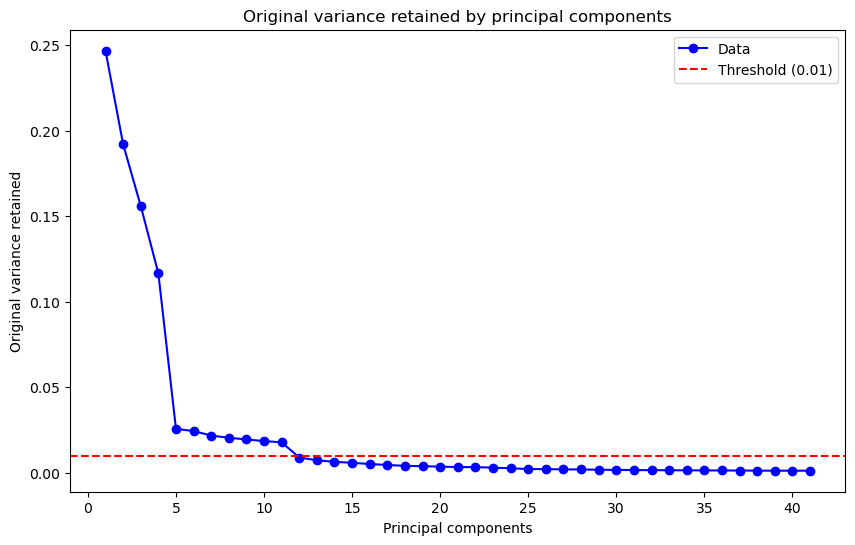

In [788]:
a = list(range(1, 42))
b = [0.24680375, 0.19215969, 0.15605659, 0.11666065, 0.02572885, 0.02443538, 
     0.0218341,  0.02049129, 0.01956284, 0.01857763, 0.01785378, 0.00897626, 
     0.00733669, 0.00644145, 0.00587337, 0.00518885, 0.00460725, 0.00411484, 
     0.00391085, 0.00364478, 0.00339451, 0.00334607, 0.00305996, 0.00269267, 
     0.00222557, 0.00218068, 0.00204467, 0.00198479, 0.00183729, 0.00172785, 
     0.00163368, 0.00157033, 0.00154236, 0.00147121, 0.00144341, 0.00139423, 
     0.0013668, 0.0012963,  0.00126862, 0.00126025, 0.00125186]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(a, b, marker='o', color='b', linestyle='-', label='Data')

# Add horizontal dashed red line at y = 0.01
plt.axhline(y=0.01, color='r', linestyle='--', label='Threshold (0.01)')

# Labels and title
plt.title('Original variance retained by principal components')
plt.xlabel('Principal components')
plt.ylabel('Original variance retained')

# Show the plot
plt.grid(False)
plt.legend()
plt.show()